In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler

In [2]:
torch.manual_seed(42)
np.random.seed(42)

In [4]:
# Load the data
df = pd.read_csv('data.csv', index_col='Date', parse_dates=True)
df.head()

/var/folders/hd/hqx41svd20lcfdp6nt85c0j80000gn/T/ipykernel_3487/2860443613.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv('data.csv', index_col='Date', parse_dates=True)


,1,2,3,4,5,6,7,8,9,10,...,7723955,30369354,34703847,36200067,36671067,37052366,38834077,39168240,39379024,Grand Total
Date,,,,,,,,,,,,,,,,,,,,,
22-Mar,NaN,92.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,92
23-Mar,NaN,85.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,85
24-Mar,208.0,44.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,126
25-Mar,68.0,59.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,63
26-Mar,46.0,48.0,NaN,22.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39


In [5]:
# Assume we're predicting 'Grand Total' column
# If you have a different target column, change it here
target_col = 'Grand Total'

# Extract the target series
data = df[target_col].values.reshape(-1, 1)

# Scale the data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

In [6]:
# Create sequences for LSTM
def create_sequences(data, lookback=7):
    X, y = [], []
    for i in range(len(data) - lookback):
        X.append(data[i:i+lookback])
        y.append(data[i+lookback])
    return np.array(X), np.array(y)

lookback = 7  # Use past 7 days to predict next day
X, y = create_sequences(data_scaled, lookback)

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

X shape: (1284, 7, 1)
y shape: (1284, 1)


In [7]:
# Train/test split (80/20)
split_index = int(0.8 * len(X))

X_train = torch.FloatTensor(X[:split_index])
y_train = torch.FloatTensor(y[:split_index])
X_test = torch.FloatTensor(X[split_index:])
y_test = torch.FloatTensor(y[split_index:])

print(f"Train size: {len(X_train)}")
print(f"Test size: {len(X_test)}")

Train size: 1027
Test size: 257


In [8]:
# Define LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, 
                           batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        # LSTM output
        lstm_out, _ = self.lstm(x)
        # Take the last time step
        out = self.fc(lstm_out[:, -1, :])
        return out

# Initialize model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LSTMModel().to(device)
print(model)
print(f"Using device: {device}")

LSTMModel(
  (lstm): LSTM(1, 64, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)
Using device: cpu


In [9]:
# Training setup
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 100

train_losses = []
val_losses = []

In [10]:
# Training loop
for epoch in range(num_epochs):
    model.train()
    
    # Forward pass
    outputs = model(X_train.to(device))
    loss = criterion(outputs, y_train.to(device))
    
    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    train_losses.append(loss.item())
    
    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_test.to(device))
        val_loss = criterion(val_outputs, y_test.to(device))
        val_losses.append(val_loss.item())
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.6f}, Val Loss: {val_loss.item():.6f}')

Epoch [10/100], Train Loss: 0.028547, Val Loss: 0.018145
Epoch [20/100], Train Loss: 0.028137, Val Loss: 0.018673
Epoch [30/100], Train Loss: 0.027046, Val Loss: 0.010515
Epoch [40/100], Train Loss: 0.023899, Val Loss: 0.016494
Epoch [50/100], Train Loss: 0.020287, Val Loss: 0.011102
Epoch [60/100], Train Loss: 0.014897, Val Loss: 0.008355
Epoch [70/100], Train Loss: 0.012750, Val Loss: 0.003777
Epoch [80/100], Train Loss: 0.011917, Val Loss: 0.004533
Epoch [90/100], Train Loss: 0.011520, Val Loss: 0.004355
Epoch [100/100], Train Loss: 0.011024, Val Loss: 0.003687


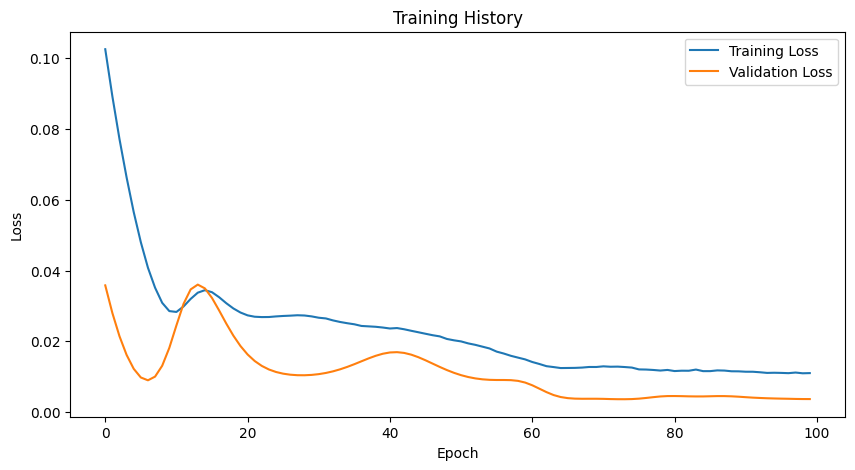

In [11]:
# Plot training history
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training History')
plt.legend()
plt.show()

In [12]:
# Get predictions on training set
model.eval()
with torch.no_grad():
    train_predictions = model(X_train.to(device)).cpu().numpy()
    train_predictions = scaler.inverse_transform(train_predictions)
    
    # Get actual training values
    y_train_actual = scaler.inverse_transform(y_train.numpy())

In [13]:
# Get predictions on test set
with torch.no_grad():
    test_predictions = model(X_test.to(device)).cpu().numpy()
    test_predictions = scaler.inverse_transform(test_predictions)
    
    # Get actual test values
    y_test_actual = scaler.inverse_transform(y_test.numpy())

In [14]:
# Calculate evaluation metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

train_mse = mean_squared_error(y_train_actual, train_predictions)
train_mae = mean_absolute_error(y_train_actual, train_predictions)
train_r2 = r2_score(y_train_actual, train_predictions)

test_mse = mean_squared_error(y_test_actual, test_predictions)
test_mae = mean_absolute_error(y_test_actual, test_predictions)
test_r2 = r2_score(y_test_actual, test_predictions)

print("Training Metrics:")
print(f"MSE: {train_mse:.2f}")
print(f"MAE: {train_mae:.2f}")
print(f"R²: {train_r2:.4f}")

print("\nTest Metrics:")
print(f"MSE: {test_mse:.2f}")
print(f"MAE: {test_mae:.2f}")
print(f"R²: {test_r2:.4f}")

Training Metrics:
MSE: 688.92
MAE: 16.53
R²: 0.6149

Test Metrics:
MSE: 234.13
MAE: 10.69
R²: 0.5880


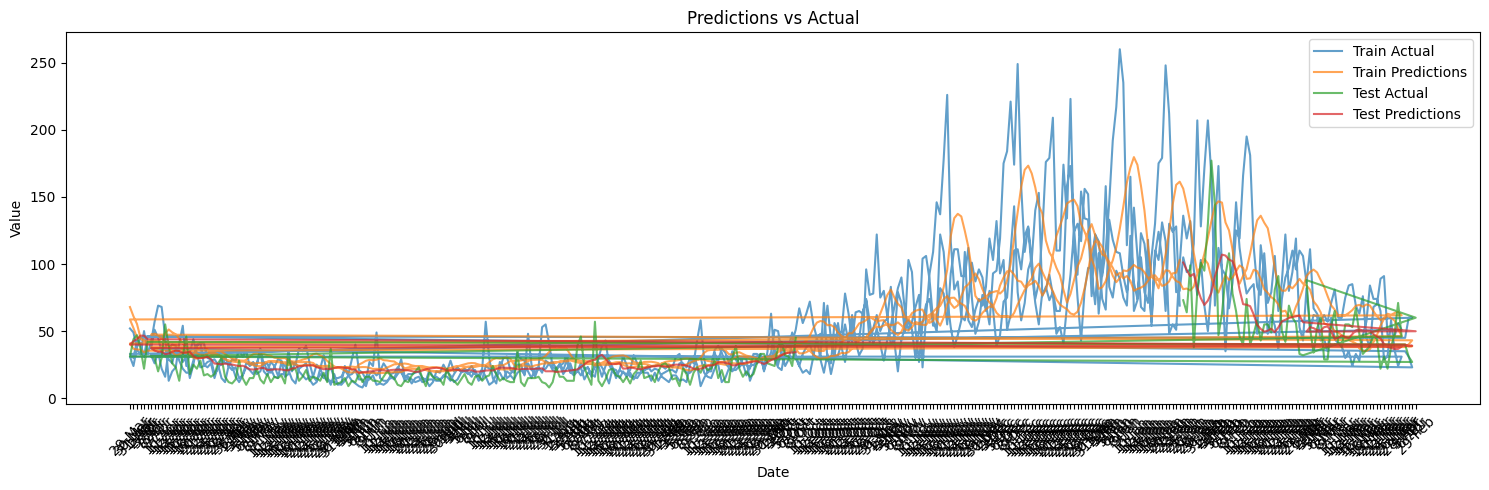

In [15]:
# Plot results
plt.figure(figsize=(15, 5))

# Get dates for plotting (offset by lookback)
train_dates = df.index[lookback:lookback+split_index]
test_dates = df.index[lookback+split_index:]

plt.plot(train_dates, y_train_actual, label='Train Actual', alpha=0.7)
plt.plot(train_dates, train_predictions, label='Train Predictions', alpha=0.7)
plt.plot(test_dates, y_test_actual, label='Test Actual', alpha=0.7)
plt.plot(test_dates, test_predictions, label='Test Predictions', alpha=0.7)

plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Predictions vs Actual')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [16]:
# Optional: Forecast future values
def forecast_future(model, last_sequence, n_steps, scaler, device):
    model.eval()
    predictions = []
    current_seq = last_sequence.clone()
    
    with torch.no_grad():
        for _ in range(n_steps):
            # Predict next value
            pred = model(current_seq.unsqueeze(0).to(device))
            predictions.append(pred.cpu().numpy()[0, 0])
            
            # Update sequence: remove first value, add prediction
            current_seq = torch.cat([current_seq[1:], pred.cpu()], dim=0)
    
    # Inverse transform predictions
    predictions = np.array(predictions).reshape(-1, 1)
    predictions = scaler.inverse_transform(predictions)
    
    return predictions

# Forecast next 30 days
last_sequence = X_test[-1]
future_predictions = forecast_future(model, last_sequence, 30, scaler, device)

print(f"Forecasted next 30 values: {future_predictions.flatten()[:5]}...")  # Show first 5

Forecasted next 30 values: [34.29947  34.966827 35.851273 35.31014  34.64808 ]...
